# Software profesional en Acústica 2024-25 (M2i)

*This notebook contains a modification of the notebook [ShapeFunctions](https://github.com/garth-wells/notebooks-3D7), used in the course **3D7 Finite Element Methods** in the University of Cambridge, and created by Garth N. Wells. The code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# Finite element shape functions (basis functions of the discrete space)

This notebook explores the computation of finite element shape functions. We start with the one-dimensional case.

We will use NumPy to compute the shape functions, and Matplotlib to visualise the shape functions, so we need to import both:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Lagrange polynomials in 1D

We start with the example of a cubic finite element basis, and then develop a function for plotting shape functions of any order. In all cases we consider the interval $(-1, 1)$.

### Cubic basis

Cubic shape functions will have the form:

$$
N_{i}(x) = c_{0} + c_{1} x + c_{2} x^{2} + c_{2}x^{3}
$$

Recall the shape function $N_{i}$ should be equal to one at its own node ($N_{i}(x_{i}) = 1$) and zero at all other nodes ($N_{i}(x_{i}) = 0$ when  $i \ne j$).

The cubic function has four coefficients, so we need four nodes. First step is to create the nodes on the interval $(-1, 1)$. We will consider equally spaced nodes, in which case we can use the `linspace` function:

In [2]:
x_n = np.linspace(-1.0, 1.0, 4)
print(x_n)

[-1.         -0.33333333  0.33333333  1.        ]


Next, we construct the Vandermonde matrix for a third-order polynomial and the points `x_n`: 

In [3]:
A = np.vander(x_n, 4)

We can now compute the four shape functions by solving $\boldsymbol{A} \boldsymbol{c}_{i} = \boldsymbol{f}_{i}$ to get the polynomial coefficients $\boldsymbol{c}_{i}$ for the shape function $N_{i}$. For node $i$, $f_{j=1} = 1$ if $i=j$ and $f_{j} = 0$ if $i \ne j$. We use a loop to compute the four shape functions at once:

In [4]:
shape_functions = []
for i in range(4):
    f = np.zeros(4)
    f[i] = 1.0
    c = np.linalg.solve(A, f)
    
    shape_functions.append(np.poly1d(c))
    print("-Shape function for node {}: \n{}".format(i, shape_functions[-1]))

-Shape function for node 0: 
         3          2
-0.5625 x + 0.5625 x + 0.0625 x - 0.0625
-Shape function for node 1: 
       3          2
1.688 x - 0.5625 x - 1.688 x + 0.5625
-Shape function for node 2: 
        3          2
-1.688 x - 0.5625 x + 1.688 x + 0.5625
-Shape function for node 3: 
        3          2
0.5625 x + 0.5625 x - 0.0625 x - 0.0625


We can now plot each shape function (we compute each shape function at 200 points to plot the function).

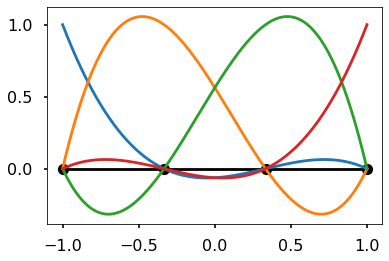

In [5]:
# Evaluate the polynomial at the points
x = np.linspace(-1.0, 1.0, 200) 
plt.plot(x_n, np.zeros(4), '-o', color='k');
for shape_function in shape_functions:
    N = shape_function(x)
    plt.plot(x, N);

We can use NumPy to compute the derivatives of the shape function, and then plot these.

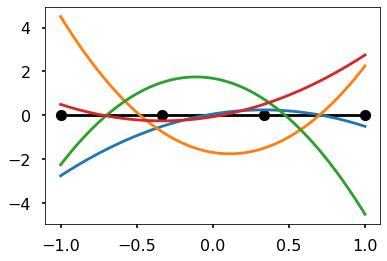

In [6]:
x = np.linspace(-1.0, 1.0, 200) 
plt.plot(x_n, np.zeros(len(x_n)), '-o', color='k');
for shape_function in shape_functions:
    dshape_function = np.polyder(shape_function)
    dN = dshape_function(x)
    plt.plot(x, dN);

### Arbitary degree Lagrange polynomials

We now write a function that performs the above tasks so we can compute and plot shape functions on any degree. The argument to the function, `n`, is the polynomial degree of the shape functions that we wish to compute. 

In [7]:
def plot_lagrange(n):
    n = n + 1 # number of nodes
    x_n = np.linspace(-1.0, 1.0, n)
    A = np.vander(x_n, len(x_n))
    
    f = np.zeros(n)

    shape_functions = []
    x = np.linspace(-1.0, 1.0, 200) 
    plt.plot(x_n, np.zeros(len(x_n)), '-o', color='k');
    for i in range(n):
        f = np.zeros(n)
        f[i] = 1.0
        c = np.linalg.solve(A, f)
    
        plt.plot((x_n, x_n), (0.0, 1.0), '--', color='k');

        p = np.poly1d(c)
        N = p(x)
        plt.plot(x, N);

For a $5\text{-th}$ order polynomial:

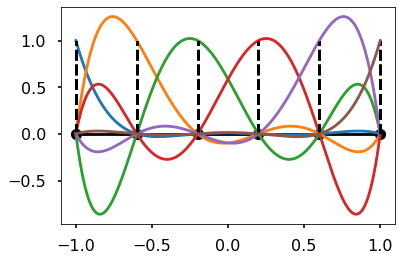

In [8]:
plot_lagrange(5) 

For a $10\text{-th}$ order polynomial:

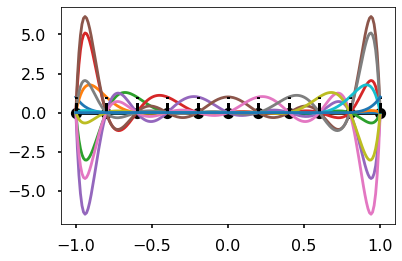

In [9]:
plot_lagrange(10) 

For the $10\text{-th}$ order polynomial, note the oscillations near the ends of the element. This is known as Runge's phenomena when interpolating points with a polynomial. This element, with equally spaces nodes, wouldn't be recommended in a simulation.

## Hermitian shape functions

The below function plots Hermitian shape functions of arbitrary degree.

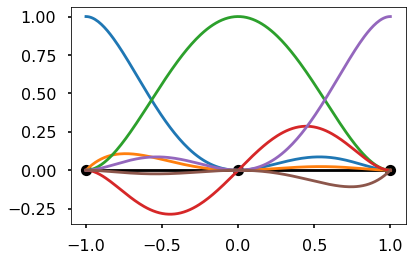

In [13]:
def row(x, n):
    "For a point x, compute the 'N' and 'M' rows in the interpolation matrix for degree n"
    a = np.zeros((2, n + 1))
    for i in range(n + 1):
        a[0, i] = np.power(x, i) 
    for i in range(1, n + 1):
        a[1, i] = i*np.power(x, i - 1) 
    return a

# Element nodes
num_nodes = 3
x_n = np.linspace(-1.0, 1.0, num_nodes)
plt.plot(x_n, np.zeros(len(x_n)), '-o', color='k');

# Polynomial degree
degree = 2*num_nodes -1

# Build Vandermonde matrix
V = np.zeros((0, 2*len(x_n))) 
#V = None
for i in range(len(x_n)):
    V = np.vstack((V, row(x_n[i], degree)))
    
# Points for plotting
x = np.linspace(-1.0, 1.0, 200) 

# Solve Vandermonde matrix while cycling through RHS, and plot
for i in range(2*len(x_n)):
    b = np.zeros(2*len(x_n))
    b[i] = 1.0
    
    # Solve for polynomial coefficients
    c = np.linalg.solve(V, b)

    # Reverse order of coefficients since NumPy polyn1d functions wants coefficients 
    # in order [x^4, x^3, . . . 1], etc.
    c = c[::-1] 
    
    # Create polynimial for plotting
    p = np.poly1d(c)
    N = p(x)
    plt.plot(x, N);    